In [1]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import tqdm
import torch.nn as nn

In [55]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [56]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
classes = os.listdir('Data/images_original')
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

images = []
labels = []
for i, cls_name in enumerate(classes):
    path = os.path.join('Data/images_original', cls_name)
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)
        images.append(img)
        labels.append(i)
images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)
print(images.shape, labels.shape)

torch.Size([999, 3, 224, 224]) torch.Size([999])


In [58]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [59]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=42)
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape)

torch.Size([799, 3, 224, 224]) torch.Size([200, 3, 224, 224]) torch.Size([799]) torch.Size([200])


Text(0.5, 1.0, 'jazz')

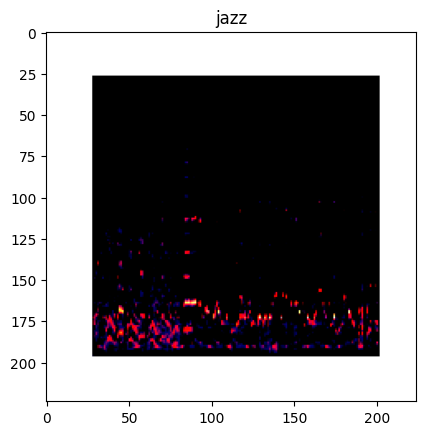

In [60]:
# print a image from the dataset
import matplotlib.pyplot as plt

plt.imshow(train_images[110].cpu().numpy().transpose(1, 2, 0))
plt.title(idx_to_class[train_labels[110].item()])

In [61]:

class MusicDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [62]:
dataset_train = MusicDataset(train_images, train_labels)
DataLoader_train = DataLoader(dataset_train, batch_size=50, shuffle=True)

In [63]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [67]:
from torchvision.models import vgg19
model = vgg19(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

model.avgpool = Identity()

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)

model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [68]:
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
num_epochs = 300
patience = 15  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to keep track of the number of epochs without improvement
log = {}


for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for images, labels in tqdm.tqdm(DataLoader_train):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        pred = torch.argmax(test_outputs, dim=1)
        acc = (pred == test_labels).sum().item() / len(test_labels)

        # save the loss and accuracy
        log[epoch] = {'loss_train': loss.item(), 'loss_val': test_loss.item(), 'accuracy_val': acc}
        print(f'Epoch {epoch}, loss_train: {loss.item() / len(DataLoader_train)}, loss_val: {test_loss.item()}, accuracy_val: {acc}')

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'find-tuned-vgg.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Epoch 0, loss_train: 0.14147788286209106, loss_val: 2.0461575984954834, accuracy_val: 0.275


100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Epoch 1, loss_train: 0.11256866157054901, loss_val: 1.7315908670425415, accuracy_val: 0.44


100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Epoch 2, loss_train: 0.11232107877731323, loss_val: 1.4877068996429443, accuracy_val: 0.465


100%|██████████| 16/16 [00:02<00:00,  5.71it/s]


Epoch 3, loss_train: 0.09857981652021408, loss_val: 1.3799045085906982, accuracy_val: 0.515


100%|██████████| 16/16 [00:02<00:00,  5.70it/s]


Epoch 4, loss_train: 0.08827432245016098, loss_val: 1.294062614440918, accuracy_val: 0.535


100%|██████████| 16/16 [00:02<00:00,  5.70it/s]


Epoch 5, loss_train: 0.0543968491256237, loss_val: 1.1753191947937012, accuracy_val: 0.575


100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch 6, loss_train: 0.052727289497852325, loss_val: 1.1255176067352295, accuracy_val: 0.62


100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch 7, loss_train: 0.06571488827466965, loss_val: 1.0616832971572876, accuracy_val: 0.64


100%|██████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch 8, loss_train: 0.03920059651136398, loss_val: 1.0677241086959839, accuracy_val: 0.64


100%|██████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch 9, loss_train: 0.04016546532511711, loss_val: 1.1211111545562744, accuracy_val: 0.625


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 10, loss_train: 0.04252101480960846, loss_val: 1.0286717414855957, accuracy_val: 0.67


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 11, loss_train: 0.03570150211453438, loss_val: 1.1004862785339355, accuracy_val: 0.655


100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 12, loss_train: 0.02411029487848282, loss_val: 1.2193114757537842, accuracy_val: 0.65


100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 13, loss_train: 0.027886103838682175, loss_val: 1.303288221359253, accuracy_val: 0.605


100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 14, loss_train: 0.03480253741145134, loss_val: 1.1574209928512573, accuracy_val: 0.635


100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 15, loss_train: 0.027502307668328285, loss_val: 1.3478784561157227, accuracy_val: 0.615


100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch 16, loss_train: 0.02177617698907852, loss_val: 1.2270087003707886, accuracy_val: 0.66


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 17, loss_train: 0.01861315779387951, loss_val: 1.2387034893035889, accuracy_val: 0.63


100%|██████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch 18, loss_train: 0.008181529119610786, loss_val: 1.4332902431488037, accuracy_val: 0.65


100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch 19, loss_train: 0.013150743208825588, loss_val: 1.3508830070495605, accuracy_val: 0.65


100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch 20, loss_train: 0.018280500546097755, loss_val: 1.526210069656372, accuracy_val: 0.655


100%|██████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch 21, loss_train: 0.02146727964282036, loss_val: 1.4533003568649292, accuracy_val: 0.675


100%|██████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch 22, loss_train: 0.007510902360081673, loss_val: 1.5504333972930908, accuracy_val: 0.655


100%|██████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch 23, loss_train: 0.011682013049721718, loss_val: 1.4852566719055176, accuracy_val: 0.635


100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch 24, loss_train: 0.010403943248093128, loss_val: 1.3541765213012695, accuracy_val: 0.68


100%|██████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch 25, loss_train: 0.002472061663866043, loss_val: 1.4994065761566162, accuracy_val: 0.645
Early stopping at epoch 25


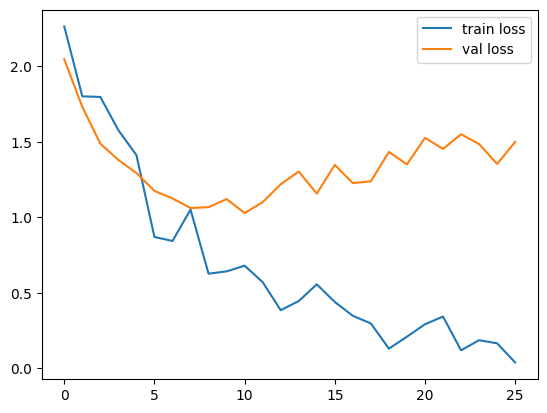

In [69]:
# draw the loss and accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot([log[k]['loss_train'] for k in log], label='train loss')
plt.plot([log[k]['loss_val'] for k in log], label='val loss')
plt.legend()
plt.show()


In [70]:
# load the model
model.load_state_dict(torch.load('find-tuned-vgg.pth'))

# test the model
model.eval()
from sklearn.metrics import classification_report

print(classification_report(test_labels.detach().cpu().numpy(), torch.argmax(model(test_images), dim=1).detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60        21
           1       0.83      0.83      0.83        12
           2       0.59      0.54      0.57        24
           3       0.55      0.55      0.55        22
           4       0.80      0.80      0.80        15
           5       0.77      0.89      0.83        27
           6       1.00      0.83      0.91        18
           7       0.43      0.84      0.57        19
           8       0.68      0.68      0.68        22
           9       1.00      0.25      0.40        20

    accuracy                           0.67       200
   macro avg       0.73      0.68      0.67       200
weighted avg       0.72      0.67      0.66       200

